# Getting started on jupyter.nersc.gov
Lets first setup the DESI environment and install the DESI-specific kernel
```bash
source /global/common/software/desi/desi_environment.sh 19.12
${DESIMODULES}/install_jupyter_kernel.sh 19.12
```
See [https://desi.lbl.gov/trac/wiki/Computing/JupyterAtNERSC](https://desi.lbl.gov/trac/wiki/Computing/JupyterAtNERSC) for more details. 

Now we can import DESI-specific python packages from [desihub](https://github.com/desihub/). 


# Reading DESI spectra
For instance we can use `desispec` to read in some DESI BGS coadded spectra from Comissioning that I've included in the repo

In [1]:
from desispec.io import read_spectra

In [2]:
# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [3]:
spectra = read_spectra('coadd-66003-20200315-1-00055654.few.fits') # handful of BGS galaxies from Tile 66003 observed on 03/15/2020, Petal #1, Exposure #00055654

(-5, 20)

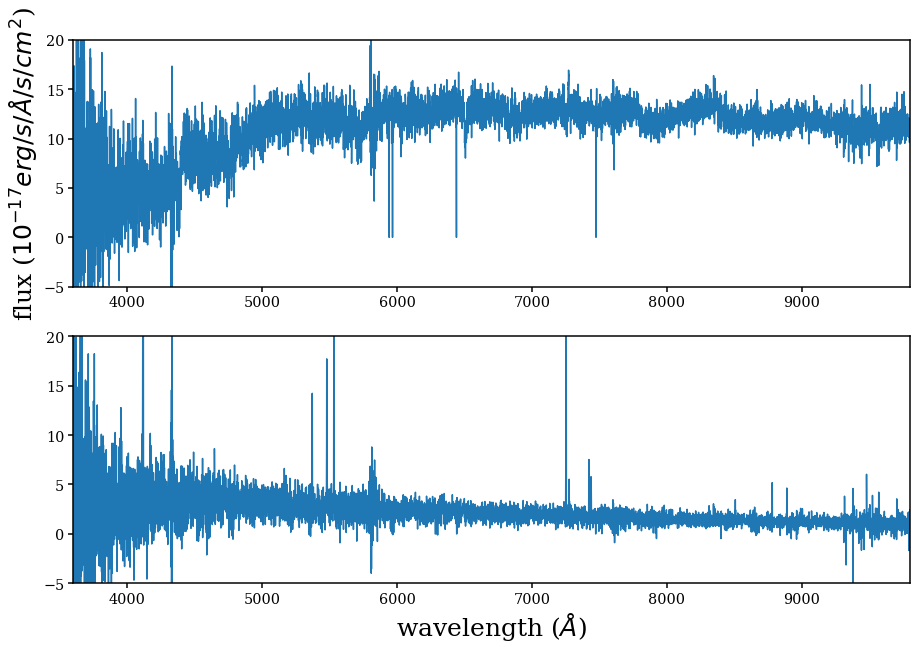

In [4]:
fig = plt.figure(figsize=(15,10))
sub = fig.add_subplot(211)
sub.plot(spectra.wave['brz'], spectra.flux['brz'][2])
sub.set_xlim(3.6e3, 9.8e3)
sub.set_ylabel('flux ($10^{-17} erg/s/\AA/s/cm^2$)', fontsize=25)
sub.set_ylim(-5, 20)

sub = fig.add_subplot(212)
sub.plot(spectra.wave['brz'], spectra.flux['brz'][6])
sub.set_xlabel('wavelength ($\AA$)', fontsize=25)
sub.set_xlim(3.6e3, 9.8e3)
#sub.set_ylabel('flux ($10^{-17} erg/s/\AA/s/cm^2$)', fontsize=25)
sub.set_ylim(-5, 20)

# Fitting Redshifts using `redrock`
The main goal of DESI is to measure the redshifts of millions of galaxies. Redshifts will be measured for galaxy spectra, like the ones above using `redrock`: https://github.com/desihub/redrock

`redrock` can be easily run on DESI spectra on the command line

In [5]:
f_spec = 'coadd-66003-20200315-1-00055654.few.fits'
f_rr_h5 = 'redrock.coadd.h5'
f_rr = 'zbest.coadd.fits'
print(f_rr)
!rrdesi -o $f_rr_h5 -z $f_rr $f_spec

zbest.coadd.fits
Running on a NERSC login node- reducing number of processes to 4
Running with 4 processes
Loading targets...
Read and distribution of 14 targets: 0.2 seconds
DEBUG: Read templates from /global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/code/redrock-templates/0.7
DEBUG: Using default redshift range -0.0050-1.6997 for rrtemplate-galaxy.fits
DEBUG: Using default redshift range 0.0500-5.9934 for rrtemplate-qso.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-A.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-B.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-CV.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-F.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-G.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-K.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-M.fits
DEBUG: U

# `redrock` outputs
Lets take a look at what `redrock` outputs

In [6]:
from astropy.table import Table

In [7]:
zbest = Table.read('zbest.coadd.fits', hdu=1)

In [8]:
zbest

TARGETID,CHI2,COEFF [10],Z,ZERR,ZWARN,NPIXELS,SPECTYPE,SUBTYPE,NCOEFF,DELTACHI2,NUMEXP,NUMTILE
int64,float64,float64,float64,float64,int64,int64,str6,str20,int64,float64,int32,int32
35191325322120560,9584.261575043201,893.4332848539528 .. -16.77252663040923,0.10123350808071664,6.014436091178413e-06,0,7703,GALAXY,,10,1635.6535873212852,1,0
35191328585287135,9313.002179399133,78.09245579846045 .. -14.490429372869063,0.43619144004787075,6.182408354377755e-05,4,7712,GALAXY,,10,2.5002987310290337,1,0
35191328585287804,9873.792814763263,3012.790663701007 .. 96.05342439232844,0.10406535134163217,3.019956341185286e-05,0,7730,GALAXY,,10,2311.1771023878828,1,0
35191328585287825,9168.213855830487,-61.73808099164275 .. -4.438967881479191,0.12779998106619883,6.344918085279259e-05,4,7696,GALAXY,,10,7.544032844249159,1,0
35191328585288430,8881.041140466928,467.184152955513 .. -23.178174619217835,0.0642016838875532,1.2092513884340853e-05,0,7721,GALAXY,,10,278.6844601929188,1,0
35191328585288609,9080.111917190254,235.21942983628742 .. 17.62718671627059,0.5348863211543592,8.889149423132466e-05,0,7723,GALAXY,,10,163.46652482450008,1,0
35191328585289115,9269.634464979172,1400.3738117079895 .. 19.437216486559063,0.10480353487252056,3.1694415123108796e-06,0,7699,GALAXY,,10,3738.88587975502,1,0
35191328585289143,9120.210827998817,308.8047397333333 .. -0.644643658630503,0.4693004306386592,6.729416876793424e-05,0,7743,GALAXY,,10,291.5425673946738,1,0
35191328589480053,9448.756339073181,176.10363079830177 .. 0.9427852618545958,0.2963883406991665,2.0448923690448925e-05,0,7696,GALAXY,,10,154.52403151988983,1,0


In [9]:
import redrock.templates

In [10]:
templates = dict()
for filename in redrock.templates.find_templates():
    t = redrock.templates.Template(filename)
    templates[(t.template_type, t.sub_type)] = t

DEBUG: Read templates from /global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/code/redrock-templates/0.7
DEBUG: Using default redshift range -0.0050-1.6997 for rrtemplate-galaxy.fits
DEBUG: Using default redshift range 0.0500-5.9934 for rrtemplate-qso.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-A.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-B.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-CV.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-F.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-G.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-K.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-M.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-WD.fits


## `redrock` galaxy templates
`redrock` fits galaxy spectra with a linear combination of PCA templates. Here's what the galaxy templates look like:

(-0.02, 0.02)

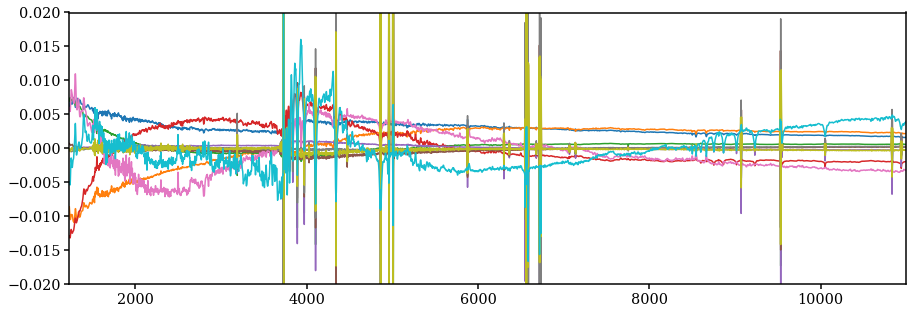

In [11]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(111)
for i in range(templates[('GALAXY', '')].flux.shape[0]):
    sub.plot(templates[('GALAXY', '')].wave, templates[('GALAXY', '')].flux[i])
sub.set_xlim(templates[('GALAXY', '')].wave.min(), templates[('GALAXY', '')].wave.max())
sub.set_ylim(-0.02, 0.02)

Since the `redrock` output file contains the coefficients of the PCA templates, we can use these templates to reconstruct the best-fit `redrock` fit

In [12]:
i = 2 
z = zbest['Z'][i]
targetid = zbest['TARGETID'][i]
ncoeff = templates[(zbest['SPECTYPE'][i].strip(), zbest['SUBTYPE'][i].strip())].flux.shape[0]
coeff = zbest['COEFF'][i][0:ncoeff]

In [13]:
tflux = templates[(zbest['SPECTYPE'][i].strip(), zbest['SUBTYPE'][i].strip())].flux.T.dot(coeff)
twave = templates[(zbest['SPECTYPE'][i].strip(), zbest['SUBTYPE'][i].strip())].wave * (1+z)

(3500, 10000)

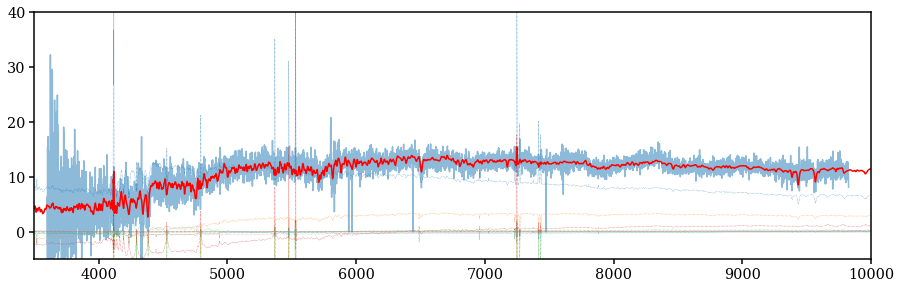

In [14]:
fig = plt.figure(figsize=(15,10))
sub = fig.add_subplot(211)

for band in spectra.bands:
    sub.plot(spectra.wave[band], spectra.flux[band][i], 'C0', alpha=0.5)

for icoeff in range(ncoeff): 
    sub.plot(twave, templates[(zbest['SPECTYPE'][i].strip(), zbest['SUBTYPE'][i].strip())].flux[icoeff] * coeff[icoeff], ls=':', lw=0.5)
sub.plot(twave, tflux, 'r-')
sub.set_ylim(-5, 40)
sub.set_xlim(3500, 10000)

For more details on the redrock output check out the following tutorials: 
- https://github.com/desihub/tutorials/blob/master/redrock/RedrockOutputs.ipynb
- https://github.com/desihub/tutorials/blob/master/redrock/RedrockPlotSpec.md